# Requirements and Data download

## Import Required libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support, \
    classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import pickle
import os
os.environ["KERAS_BACKEND"] = "torch"
import re
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import gdown
from google.colab import drive
import shutil


## Use GPU and Cuda

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


## Download and reading dataset
### You can request to my email to get the dataset
### kasrasmd32@gmail.com

In [ ]:
!gdown 1KKFVPK70CJfd4AtOw4xiT2dqPrMqTWIw
!unzip 2_output_RhythmDataFrames.zip > /dev/null 2>&1

Downloading...
From: https://drive.google.com/uc?id=1KKFVPK70CJfd4AtOw4xiT2dqPrMqTWIw
To: /content/RhythmsDataFrames.zip
100% 7.30M/7.30M [00:00<00:00, 21.2MB/s]


### Model and another files will save on this drive
### kasraworkcolab4@gmail.com

In [ ]:
drive.mount('/content/drive')
destination_save_path = '/content/drive/My Drive/Final_project_model_training_verse'
os.makedirs(destination_save_path, exist_ok=True)

Mounted at /content/drive


In [ ]:
poets_list = ["babataher", "bidel", "ferdousi", "hafez", "saeb", "saadi", "moulavi", "bahar", "parvin", "shahriar",
             "vahshi", "khajoo", "ouhadi"]

save_csvs_folder = r"2_output_RhythmDataFrames"

In [ ]:
csvs_list = []
for p in poets_list:
    poet_csv_path = os.path.join(save_csvs_folder, p, f"{p}.csv")
    poet_csv = pd.read_csv(poet_csv_path)
    csvs_list.append(poet_csv)



In [ ]:
csvs_list[0]

,poem_id,book_name,count,title,verses,verse_number,label,poet,Rhythm
0,1,دوبیتی‌ها,1,دوبیتی شمارهٔ ۱,ببندم شال و میپوشم قدک را / بنازم گردش چرخ و ف...,2,dobeyti,babataher,مفاعیلن مفاعیلن فعولن (هزج مسدس محذوف یا وزن د...
1,2,دوبیتی‌ها,2,دوبیتی شمارهٔ ۲,تن محنت کشی دیرم خدایا / دل با غم خوشی دیرم خد...,2,dobeyti,babataher,مفاعیلن مفاعیلن فعولن (هزج مسدس محذوف یا وزن د...
2,3,دوبیتی‌ها,3,دوبیتی شمارهٔ ۳,اگر یار مرا دیدی به خلوت / بگو ای بی‌وفا ای بی...,2,dobeyti,babataher,مفاعیلن مفاعیلن فعولن (هزج مسدس محذوف یا وزن د...
3,4,دوبیتی‌ها,4,دوبیتی شمارهٔ ۴,ته که ناخوانده‌ای علم سماوات / ته که نابرده‌ای...,2,dobeyti,babataher,مفاعیلن مفاعیلن فعولن (هزج مسدس محذوف یا وزن د...
4,5,دوبیتی‌ها,5,دوبیتی شمارهٔ ۵,دلی دیرم خریدار محبت / کز او گرم است بازار محب...,2,dobeyti,babataher,مفاعیلن مفاعیلن فعولن (هزج مسدس محذوف یا وزن د...
...,...,...,...,...,...,...,...,...,...
363,364,دوبیتی‌ها,364,دوبیتی شمارهٔ ۳۶۴,پی مرگ نکویان گل نرویی / دگر رویی نه رنگش بی ن...,2,dobeyti,babataher,مفاعیلن مفاعیلن فعولن (هزج مسدس محذوف یا وزن د...
364,365,دوبیتی‌ها,365,دوبیتی شمارهٔ ۳۶۵,مو احوالم خرابه گر تو جویی / جگر بندم کبابه گر...,2,dobeyti,babataher,مفاعیلن مفاعیلن فعولن (هزج مسدس محذوف یا وزن د...
365,366,دوبیتی‌ها,366,دوبیتی شمارهٔ ۳۶۶,به جز این مو ندارم آرزویی / که باشد همدم مو لا...,2,dobeyti,babataher,مفاعیلن مفاعیلن فعولن (هزج مسدس محذوف یا وزن د...
366,367,قصاید,1,باباطاهر - قصیده,بتا تا زار چون تو دلبرستم / بتن عود و بسینه مج...,22,ghaside,babataher,مفاعیلن مفاعیلن فعولن (هزج مسدس محذوف یا وزن د...


# Dataset Preprocessing

## Check Null values are there in 'Rhythm' column and drop them

In [ ]:
total_Rhythm_nulls = 0
for index, p in enumerate(csvs_list):
    Rhythm_null = p["Rhythm"].isna().sum()
    total_Rhythm_nulls += Rhythm_null
    print(f"{poets_list[index]} : {Rhythm_null}")

print(f"\nTotal #Nulls in Rhythm columns: {total_Rhythm_nulls}")

babataher : 0
bidel : 422
ferdousi : 0
hafez : 119
saeb : 217
saadi : 872
moulavi : 3925
bahar : 627
parvin : 211
shahriar : 94
vahshi : 293
khajoo : 761
ouhadi : 2

Total #Nulls in Rhythm columns: 7543


In [ ]:
df = pd.concat(csvs_list, ignore_index=True)


In [ ]:
df


,poem_id,book_name,count,title,verses,verse_number,label,poet,Rhythm
0,1,دوبیتی‌ها,1,دوبیتی شمارهٔ ۱,ببندم شال و میپوشم قدک را / بنازم گردش چرخ و ف...,2,dobeyti,babataher,مفاعیلن مفاعیلن فعولن (هزج مسدس محذوف یا وزن د...
1,2,دوبیتی‌ها,2,دوبیتی شمارهٔ ۲,تن محنت کشی دیرم خدایا / دل با غم خوشی دیرم خد...,2,dobeyti,babataher,مفاعیلن مفاعیلن فعولن (هزج مسدس محذوف یا وزن د...
2,3,دوبیتی‌ها,3,دوبیتی شمارهٔ ۳,اگر یار مرا دیدی به خلوت / بگو ای بی‌وفا ای بی...,2,dobeyti,babataher,مفاعیلن مفاعیلن فعولن (هزج مسدس محذوف یا وزن د...
3,4,دوبیتی‌ها,4,دوبیتی شمارهٔ ۴,ته که ناخوانده‌ای علم سماوات / ته که نابرده‌ای...,2,dobeyti,babataher,مفاعیلن مفاعیلن فعولن (هزج مسدس محذوف یا وزن د...
4,5,دوبیتی‌ها,5,دوبیتی شمارهٔ ۵,دلی دیرم خریدار محبت / کز او گرم است بازار محب...,2,dobeyti,babataher,مفاعیلن مفاعیلن فعولن (هزج مسدس محذوف یا وزن د...
...,...,...,...,...,...,...,...,...,...
18611,127,جام جم,127,در معارج ارواح و ابدان و عذاب ایشان,ورندارد ز دین و دانش بهر / از تنش جان جدا کنند...,45,masnavi,ouhadi,فعلاتن مفاعلن فعلن (خفیف مسدس مخبون)
18612,128,جام جم,128,خطاب به خواجه غیاث‌الدین محمد,ای شب و روز عالم از تو بساز / شب و روزی به کار...,56,masnavi,ouhadi,فعلاتن مفاعلن فعلن (خفیف مسدس مخبون)
18613,129,جام جم,129,در معذرت و فروتنی خود و تاریخ کتاب,خاطر پاک ساکنان قبور / « روح الله روحهم بالنور...,18,masnavi,ouhadi,فعلاتن مفاعلن فعلن (خفیف مسدس مخبون)
18614,130,جام جم,130,در اعتقاد خود گوید,با چنین فقر و این تهی دستی / وندرین خاکساری و ...,16,masnavi,ouhadi,فعلاتن مفاعلن فعلن (خفیف مسدس مخبون)


In [ ]:
print(df["Rhythm"].isna().sum())

7543


In [ ]:
df.shape


(18616, 9)

In [ ]:
df.dropna(subset=['Rhythm'], inplace=True)
df.reset_index(drop=True, inplace=True)

In [ ]:
df.shape

(11073, 9)

In [ ]:
print(df["Rhythm"].isna().sum())


0


In [ ]:
df

,poem_id,book_name,count,title,verses,verse_number,label,poet,Rhythm
0,1,دوبیتی‌ها,1,دوبیتی شمارهٔ ۱,ببندم شال و میپوشم قدک را / بنازم گردش چرخ و ف...,2,dobeyti,babataher,مفاعیلن مفاعیلن فعولن (هزج مسدس محذوف یا وزن د...
1,2,دوبیتی‌ها,2,دوبیتی شمارهٔ ۲,تن محنت کشی دیرم خدایا / دل با غم خوشی دیرم خد...,2,dobeyti,babataher,مفاعیلن مفاعیلن فعولن (هزج مسدس محذوف یا وزن د...
2,3,دوبیتی‌ها,3,دوبیتی شمارهٔ ۳,اگر یار مرا دیدی به خلوت / بگو ای بی‌وفا ای بی...,2,dobeyti,babataher,مفاعیلن مفاعیلن فعولن (هزج مسدس محذوف یا وزن د...
3,4,دوبیتی‌ها,4,دوبیتی شمارهٔ ۴,ته که ناخوانده‌ای علم سماوات / ته که نابرده‌ای...,2,dobeyti,babataher,مفاعیلن مفاعیلن فعولن (هزج مسدس محذوف یا وزن د...
4,5,دوبیتی‌ها,5,دوبیتی شمارهٔ ۵,دلی دیرم خریدار محبت / کز او گرم است بازار محب...,2,dobeyti,babataher,مفاعیلن مفاعیلن فعولن (هزج مسدس محذوف یا وزن د...
...,...,...,...,...,...,...,...,...,...
11068,127,جام جم,127,در معارج ارواح و ابدان و عذاب ایشان,ورندارد ز دین و دانش بهر / از تنش جان جدا کنند...,45,masnavi,ouhadi,فعلاتن مفاعلن فعلن (خفیف مسدس مخبون)
11069,128,جام جم,128,خطاب به خواجه غیاث‌الدین محمد,ای شب و روز عالم از تو بساز / شب و روزی به کار...,56,masnavi,ouhadi,فعلاتن مفاعلن فعلن (خفیف مسدس مخبون)
11070,129,جام جم,129,در معذرت و فروتنی خود و تاریخ کتاب,خاطر پاک ساکنان قبور / « روح الله روحهم بالنور...,18,masnavi,ouhadi,فعلاتن مفاعلن فعلن (خفیف مسدس مخبون)
11071,130,جام جم,130,در اعتقاد خود گوید,با چنین فقر و این تهی دستی / وندرین خاکساری و ...,16,masnavi,ouhadi,فعلاتن مفاعلن فعلن (خفیف مسدس مخبون)


## Check value_counts of each lables

In [ ]:
df["Rhythm"].value_counts()

,count
Rhythm,
فاعلاتن فاعلاتن فاعلاتن فاعلن (رمل مثمن محذوف),1817
مفعول فاعلات مفاعیل فاعلن (مضارع مثمن اخرب مکفوف محذوف),1326
مفاعلن فعلاتن مفاعلن فعلن (مجتث مثمن مخبون محذوف),1316
فعلاتن فعلاتن فعلاتن فعلن (رمل مثمن مخبون محذوف),1293
مفاعیلن مفاعیلن مفاعیلن مفاعیلن (هزج مثمن سالم),1211
فاعلاتن فاعلاتن فاعلن (رمل مسدس محذوف یا وزن مثنوی),982
مفاعیلن مفاعیلن فعولن (هزج مسدس محذوف یا وزن دوبیتی),942
فعولن فعولن فعولن فعل (متقارب مثمن محذوف یا وزن شاهنامه),879
مفعول مفاعیل مفاعیل فعولن (هزج مثمن اخرب مکفوف محذوف),695


## Remove special characters from each verse

In [ ]:
deleted_pattern = r"(\d|[\|\[]]|\"|'ٍ|[0-9]|¬|[a-zA-Z]|[؛“،,”‘۔’’‘–]|[|\.÷+\:\-\?»\=\{}\<>\*«_…\؟!/ـ]|[۲۹۱۷۸۵۶۴۳]|[\\u\\x]|[\(\)]|[۰'ٓ۫'ٔ]|[ٓٔ]|[ًٌٍْﹼ،َُِّ«ٰ»ٖء]|\[]|\[\])"
pattern = re.compile(deleted_pattern)

In [ ]:
farsi_characters = re.compile(r"[\u0600-\u06FF\uFB50-\uFDFF]")

new_rows = []
for index, row in df.iterrows():
    verse = row["verses"].strip().split("\n")
    for beit in verse:
        arr = beit.split("/")

        m1 = pattern.sub("", arr[0]).strip()
        m2 = pattern.sub("", arr[1]).strip()
        if not m1 == "" and not m2 == "" and bool(farsi_characters.search(m1)) and bool(farsi_characters.search(m2)):
            new_row = {
                # "poem_id":  index,
                "poet": row["poet"],
                "book_name": row["book_name"],
                # "count" : row["count"],
                "title": row["title"],
                "verses": f"{m1} / {m2}",
                "Rhythm": row["Rhythm"],
                # "verse_number" : row["verse_number"],
                "label": row["label"],
            }
            new_rows.append(new_row)
verses_df = pd.DataFrame(new_rows)

In [ ]:
verses_df

,poet,book_name,title,verses,Rhythm,label
0,babataher,دوبیتی‌ها,دوبیتی شمارهٔ ۱,ببندم شال و میپوشم قدک را / بنازم گردش چرخ و ف...,مفاعیلن مفاعیلن فعولن (هزج مسدس محذوف یا وزن د...,dobeyti
1,babataher,دوبیتی‌ها,دوبیتی شمارهٔ ۱,بگردم آب دریاها سراسر / بشویم هر دو دست بی نمک را,مفاعیلن مفاعیلن فعولن (هزج مسدس محذوف یا وزن د...,dobeyti
2,babataher,دوبیتی‌ها,دوبیتی شمارهٔ ۲,تن محنت کشی دیرم خدایا / دل با غم خوشی دیرم خدایا,مفاعیلن مفاعیلن فعولن (هزج مسدس محذوف یا وزن د...,dobeyti
3,babataher,دوبیتی‌ها,دوبیتی شمارهٔ ۲,زشوق مسکن و داد غریبی / به سینه آتشی دیرم خدایا,مفاعیلن مفاعیلن فعولن (هزج مسدس محذوف یا وزن د...,dobeyti
4,babataher,دوبیتی‌ها,دوبیتی شمارهٔ ۳,اگر یار مرا دیدی به خلوت / بگو ای بی‌وفا ای بی...,مفاعیلن مفاعیلن فعولن (هزج مسدس محذوف یا وزن د...,dobeyti
...,...,...,...,...,...,...
156707,ouhadi,جام جم,دعا و ختم کتاب,مدهش جز به دست خوشخویان / گوش دارش ز سنگ بدگویان,مفعول مفاعیل مفاعیل فعولن (هزج مثمن اخرب مکفوف...,masnavi
156708,ouhadi,جام جم,دعا و ختم کتاب,در جهانش به لطف گردان کن / روزی دست شیرمردان کن,مفعول مفاعیل مفاعیل فعولن (هزج مثمن اخرب مکفوف...,masnavi
156709,ouhadi,جام جم,دعا و ختم کتاب,گر درو سهو یا خطایی هست / تو ببخشای چون عطایی هست,مفعول مفاعیل مفاعیل فعولن (هزج مثمن اخرب مکفوف...,masnavi
156710,ouhadi,جام جم,دعا و ختم کتاب,ناظران را ازو حیاتی بخش / اوحدی نیز را نجاتی بخش,مفعول مفاعیل مفاعیل فعولن (هزج مثمن اخرب مکفوف...,masnavi


## Remove Duplicated verses from dataframe

In [ ]:
verses_df.shape


(156712, 6)

In [ ]:
verses_df["verses"].nunique()

156299

In [ ]:
verses_df = verses_df.drop_duplicates(subset="verses", keep="first")


In [ ]:
verses_df

,poet,book_name,title,verses,Rhythm,label
0,babataher,دوبیتی‌ها,دوبیتی شمارهٔ ۱,ببندم شال و میپوشم قدک را / بنازم گردش چرخ و ف...,مفاعیلن مفاعیلن فعولن (هزج مسدس محذوف یا وزن د...,dobeyti
1,babataher,دوبیتی‌ها,دوبیتی شمارهٔ ۱,بگردم آب دریاها سراسر / بشویم هر دو دست بی نمک را,مفاعیلن مفاعیلن فعولن (هزج مسدس محذوف یا وزن د...,dobeyti
2,babataher,دوبیتی‌ها,دوبیتی شمارهٔ ۲,تن محنت کشی دیرم خدایا / دل با غم خوشی دیرم خدایا,مفاعیلن مفاعیلن فعولن (هزج مسدس محذوف یا وزن د...,dobeyti
3,babataher,دوبیتی‌ها,دوبیتی شمارهٔ ۲,زشوق مسکن و داد غریبی / به سینه آتشی دیرم خدایا,مفاعیلن مفاعیلن فعولن (هزج مسدس محذوف یا وزن د...,dobeyti
4,babataher,دوبیتی‌ها,دوبیتی شمارهٔ ۳,اگر یار مرا دیدی به خلوت / بگو ای بی‌وفا ای بی...,مفاعیلن مفاعیلن فعولن (هزج مسدس محذوف یا وزن د...,dobeyti
...,...,...,...,...,...,...
156707,ouhadi,جام جم,دعا و ختم کتاب,مدهش جز به دست خوشخویان / گوش دارش ز سنگ بدگویان,مفعول مفاعیل مفاعیل فعولن (هزج مثمن اخرب مکفوف...,masnavi
156708,ouhadi,جام جم,دعا و ختم کتاب,در جهانش به لطف گردان کن / روزی دست شیرمردان کن,مفعول مفاعیل مفاعیل فعولن (هزج مثمن اخرب مکفوف...,masnavi
156709,ouhadi,جام جم,دعا و ختم کتاب,گر درو سهو یا خطایی هست / تو ببخشای چون عطایی هست,مفعول مفاعیل مفاعیل فعولن (هزج مثمن اخرب مکفوف...,masnavi
156710,ouhadi,جام جم,دعا و ختم کتاب,ناظران را ازو حیاتی بخش / اوحدی نیز را نجاتی بخش,مفعول مفاعیل مفاعیل فعولن (هزج مثمن اخرب مکفوف...,masnavi


In [ ]:
verses_df["verses"].nunique()

156299

In [ ]:
verses_df.shape


(156299, 6)

In [ ]:
verses_df["Rhythm"].value_counts()


,count
Rhythm,
فعولن فعولن فعولن فعل (متقارب مثمن محذوف یا وزن شاهنامه),53604
فاعلاتن فاعلاتن فاعلن (رمل مسدس محذوف یا وزن مثنوی),20128
فاعلاتن فاعلاتن فاعلاتن فاعلن (رمل مثمن محذوف),13102
فعلاتن مفاعلن فعلن (خفیف مسدس مخبون),11502
مفاعلن فعلاتن مفاعلن فعلن (مجتث مثمن مخبون محذوف),11010
مفاعیلن مفاعیلن فعولن (هزج مسدس محذوف یا وزن دوبیتی),10486
مفعول فاعلات مفاعیل فاعلن (مضارع مثمن اخرب مکفوف محذوف),10231
فعلاتن فعلاتن فعلاتن فعلن (رمل مثمن مخبون محذوف),10228
مفاعیلن مفاعیلن مفاعیلن مفاعیلن (هزج مثمن سالم),9950


## Label Encodeing

In [ ]:
rhythm_encoder = LabelEncoder()
verses_df["Rhythm_Encoder"] = rhythm_encoder.fit_transform(verses_df["Rhythm"])


<ipython-input-30-f697ae2408fa>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  verses_df["Rhythm_Encoder"] = rhythm_encoder.fit_transform(verses_df["Rhythm"])


In [ ]:
verses_df

,poet,book_name,title,verses,Rhythm,label,Rhythm_Encoder
0,babataher,دوبیتی‌ها,دوبیتی شمارهٔ ۱,ببندم شال و میپوشم قدک را / بنازم گردش چرخ و ف...,مفاعیلن مفاعیلن فعولن (هزج مسدس محذوف یا وزن د...,dobeyti,6
1,babataher,دوبیتی‌ها,دوبیتی شمارهٔ ۱,بگردم آب دریاها سراسر / بشویم هر دو دست بی نمک را,مفاعیلن مفاعیلن فعولن (هزج مسدس محذوف یا وزن د...,dobeyti,6
2,babataher,دوبیتی‌ها,دوبیتی شمارهٔ ۲,تن محنت کشی دیرم خدایا / دل با غم خوشی دیرم خدایا,مفاعیلن مفاعیلن فعولن (هزج مسدس محذوف یا وزن د...,dobeyti,6
3,babataher,دوبیتی‌ها,دوبیتی شمارهٔ ۲,زشوق مسکن و داد غریبی / به سینه آتشی دیرم خدایا,مفاعیلن مفاعیلن فعولن (هزج مسدس محذوف یا وزن د...,dobeyti,6
4,babataher,دوبیتی‌ها,دوبیتی شمارهٔ ۳,اگر یار مرا دیدی به خلوت / بگو ای بی‌وفا ای بی...,مفاعیلن مفاعیلن فعولن (هزج مسدس محذوف یا وزن د...,dobeyti,6
...,...,...,...,...,...,...,...
156707,ouhadi,جام جم,دعا و ختم کتاب,مدهش جز به دست خوشخویان / گوش دارش ز سنگ بدگویان,مفعول مفاعیل مفاعیل فعولن (هزج مثمن اخرب مکفوف...,masnavi,9
156708,ouhadi,جام جم,دعا و ختم کتاب,در جهانش به لطف گردان کن / روزی دست شیرمردان کن,مفعول مفاعیل مفاعیل فعولن (هزج مثمن اخرب مکفوف...,masnavi,9
156709,ouhadi,جام جم,دعا و ختم کتاب,گر درو سهو یا خطایی هست / تو ببخشای چون عطایی هست,مفعول مفاعیل مفاعیل فعولن (هزج مثمن اخرب مکفوف...,masnavi,9
156710,ouhadi,جام جم,دعا و ختم کتاب,ناظران را ازو حیاتی بخش / اوحدی نیز را نجاتی بخش,مفعول مفاعیل مفاعیل فعولن (هزج مثمن اخرب مکفوف...,masnavi,9


In [ ]:
verses_df["Rhythm"].value_counts()


,count
Rhythm,
فعولن فعولن فعولن فعل (متقارب مثمن محذوف یا وزن شاهنامه),53604
فاعلاتن فاعلاتن فاعلن (رمل مسدس محذوف یا وزن مثنوی),20128
فاعلاتن فاعلاتن فاعلاتن فاعلن (رمل مثمن محذوف),13102
فعلاتن مفاعلن فعلن (خفیف مسدس مخبون),11502
مفاعلن فعلاتن مفاعلن فعلن (مجتث مثمن مخبون محذوف),11010
مفاعیلن مفاعیلن فعولن (هزج مسدس محذوف یا وزن دوبیتی),10486
مفعول فاعلات مفاعیل فاعلن (مضارع مثمن اخرب مکفوف محذوف),10231
فعلاتن فعلاتن فعلاتن فعلن (رمل مثمن مخبون محذوف),10228
مفاعیلن مفاعیلن مفاعیلن مفاعیلن (هزج مثمن سالم),9950


In [ ]:
verses_df["Rhythm_Encoder"].value_counts()


,count
Rhythm_Encoder,
4,53604
1,20128
0,13102
3,11502
5,11010
6,10486
8,10231
2,10228
7,9950


In [ ]:
verses_df.shape

(156299, 7)

In [ ]:
verses_df["Rhythm_Encoder"].value_counts().plot(kind='bar', color='purple')

plt.xlabel('Rhythm_Encoder')
plt.ylabel('Counts')
plt.title('Value Counts of Rhythm_Encoder')
plt.xticks(rotation=0)

## Sampling from each class to balance them
### We want to reach a total of 100,000 verses in classes.

In [ ]:
df_class_4 = verses_df[verses_df['Rhythm_Encoder'] == 4].sample(n=12992, random_state=40)
df_class_1 = verses_df[verses_df['Rhythm_Encoder'] == 1].sample(n=11000, random_state=40)
df_class_0 = verses_df[verses_df['Rhythm_Encoder'] == 0].sample(n=10000, random_state=40)
df_class_3 = verses_df[verses_df['Rhythm_Encoder'] == 3].sample(n=10000, random_state=40)
df_class_5 = verses_df[verses_df['Rhythm_Encoder'] == 5].sample(n=10000, random_state=40)
df_class_6 = verses_df[verses_df['Rhythm_Encoder'] == 6].sample(n=10000, random_state=40)
df_class_8 = verses_df[verses_df['Rhythm_Encoder'] == 8].sample(n=10000, random_state=40)
df_class_2 = verses_df[verses_df['Rhythm_Encoder'] == 2].sample(n=10000, random_state=40)

df_other_classes = verses_df[~verses_df['Rhythm_Encoder'].isin([4, 1, 0, 3, 5, 6, 8, 2])]

verses_df_sampled = pd.concat([df_class_4, df_class_1, df_class_0, df_class_3, df_class_5, df_class_6, df_class_8, df_class_2, df_other_classes])

verses_df_sampled.reset_index(drop=True, inplace=True)


In [ ]:
verses_df_sampled

,poet,book_name,title,verses,Rhythm,label,Rhythm_Encoder
0,ferdousi,شاهنامه\nپادشاهی اسکندر,بخش ۱۹,جهانی گرفته به مشت اندرون / نژاد سماعیل ازو پر...,فعولن فعولن فعولن فعل (متقارب مثمن محذوف یا وز...,masnavi,4
1,ferdousi,شاهنامه\nپادشاهی کسری نوشین روان چهل و هشت سال...,بخش ۵ - رزم خاقان چین با هیتالیان,بران کینه رفتم من از شهر چاج / که بستانم از غا...,فعولن فعولن فعولن فعل (متقارب مثمن محذوف یا وز...,masnavi,4
2,ferdousi,شاهنامه\nپادشاهی خسرو پرویز,بخش ۳۹,ازان پس دو ایوان بیاراستند / زهر گونه‌ای جامه‌...,فعولن فعولن فعولن فعل (متقارب مثمن محذوف یا وز...,masnavi,4
3,ferdousi,شاهنامه\nداستان هفتخوان اسفندیار,بخش ۱۱,پشوتن چنین گفت کز پیل و شیر / به تنبل فزونست م...,فعولن فعولن فعولن فعل (متقارب مثمن محذوف یا وز...,masnavi,4
4,saadi,بوستان,بوستان - باب هفتم در عالم تربیت بخش ۲۹ - حکایت,تو نیز ای عجب هر که را یک هنر / ببینی ز ده عیب...,فعولن فعولن فعولن فعل (متقارب مثمن محذوف یا وز...,NaN,4
...,...,...,...,...,...,...,...
99995,ouhadi,جام جم,دعا و ختم کتاب,مدهش جز به دست خوشخویان / گوش دارش ز سنگ بدگویان,مفعول مفاعیل مفاعیل فعولن (هزج مثمن اخرب مکفوف...,masnavi,9
99996,ouhadi,جام جم,دعا و ختم کتاب,در جهانش به لطف گردان کن / روزی دست شیرمردان کن,مفعول مفاعیل مفاعیل فعولن (هزج مثمن اخرب مکفوف...,masnavi,9
99997,ouhadi,جام جم,دعا و ختم کتاب,گر درو سهو یا خطایی هست / تو ببخشای چون عطایی هست,مفعول مفاعیل مفاعیل فعولن (هزج مثمن اخرب مکفوف...,masnavi,9
99998,ouhadi,جام جم,دعا و ختم کتاب,ناظران را ازو حیاتی بخش / اوحدی نیز را نجاتی بخش,مفعول مفاعیل مفاعیل فعولن (هزج مثمن اخرب مکفوف...,masnavi,9


In [ ]:
verses_df_sampled.shape

(100000, 7)

In [ ]:
rhythm_sampled_counts = verses_df_sampled["Rhythm_Encoder"].value_counts()
rhythm_sampled_counts

,count
Rhythm_Encoder,
4,12992
1,11000
0,10000
3,10000
5,10000
6,10000
8,10000
2,10000
7,9950


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, '4'),
  Text(1, 0, '1'),
  Text(2, 0, '0'),
  Text(3, 0, '3'),
  Text(4, 0, '5'),
  Text(5, 0, '6'),
  Text(6, 0, '8'),
  Text(7, 0, '2'),
  Text(8, 0, '7'),
  Text(9, 0, '9')])

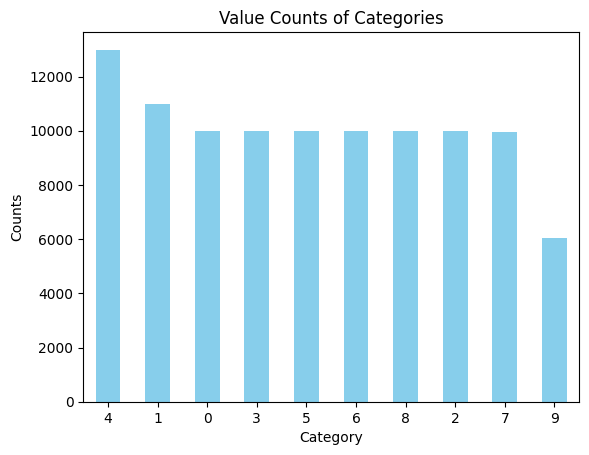

In [ ]:
rhythm_sampled_counts.plot(kind='bar', color='turquoise')

plt.xlabel('Rhythm_Encoder')
plt.ylabel('Counts')
plt.title('Value Counts of Rhythm_Encoder')
plt.xticks(rotation=0)


## Save Label Encoder and new dataframe

In [ ]:
with open(f'{destination_save_path}/Rhythm_Encoder.pkl', 'wb') as file:
    pickle.dump(rhythm_encoder, file)

verses_df_sampled.to_csv(f'{destination_save_path}/VersesRhythm_DataFrame.csv', encoding='utf-8', index=False)

# Reading Dataset, Preproccessing

## Read Label Encoder and new dataframe

In [ ]:
df = pd.read_csv(f"{destination_save_path}/VersesRhythm_DataFrame.csv")

with open(f'{destination_save_path}/Rhythm_Encoder.pkl', 'rb') as file:
    rhythm_encoder = pickle.load(file)


In [ ]:
df

,poet,book_name,title,verses,Rhythm,label,Rhythm_Encoder
0,ferdousi,شاهنامه\nپادشاهی اسکندر,بخش ۱۹,جهانی گرفته به مشت اندرون / نژاد سماعیل ازو پر...,فعولن فعولن فعولن فعل (متقارب مثمن محذوف یا وز...,masnavi,4
1,ferdousi,شاهنامه\nپادشاهی کسری نوشین روان چهل و هشت سال...,بخش ۵ - رزم خاقان چین با هیتالیان,بران کینه رفتم من از شهر چاج / که بستانم از غا...,فعولن فعولن فعولن فعل (متقارب مثمن محذوف یا وز...,masnavi,4
2,ferdousi,شاهنامه\nپادشاهی خسرو پرویز,بخش ۳۹,ازان پس دو ایوان بیاراستند / زهر گونه‌ای جامه‌...,فعولن فعولن فعولن فعل (متقارب مثمن محذوف یا وز...,masnavi,4
3,ferdousi,شاهنامه\nداستان هفتخوان اسفندیار,بخش ۱۱,پشوتن چنین گفت کز پیل و شیر / به تنبل فزونست م...,فعولن فعولن فعولن فعل (متقارب مثمن محذوف یا وز...,masnavi,4
4,saadi,بوستان,بوستان - باب هفتم در عالم تربیت بخش ۲۹ - حکایت,تو نیز ای عجب هر که را یک هنر / ببینی ز ده عیب...,فعولن فعولن فعولن فعل (متقارب مثمن محذوف یا وز...,NaN,4
...,...,...,...,...,...,...,...
99995,ouhadi,جام جم,دعا و ختم کتاب,مدهش جز به دست خوشخویان / گوش دارش ز سنگ بدگویان,مفعول مفاعیل مفاعیل فعولن (هزج مثمن اخرب مکفوف...,masnavi,9
99996,ouhadi,جام جم,دعا و ختم کتاب,در جهانش به لطف گردان کن / روزی دست شیرمردان کن,مفعول مفاعیل مفاعیل فعولن (هزج مثمن اخرب مکفوف...,masnavi,9
99997,ouhadi,جام جم,دعا و ختم کتاب,گر درو سهو یا خطایی هست / تو ببخشای چون عطایی هست,مفعول مفاعیل مفاعیل فعولن (هزج مثمن اخرب مکفوف...,masnavi,9
99998,ouhadi,جام جم,دعا و ختم کتاب,ناظران را ازو حیاتی بخش / اوحدی نیز را نجاتی بخش,مفعول مفاعیل مفاعیل فعولن (هزج مثمن اخرب مکفوف...,masnavi,9


In [ ]:
df['Rhythm'].value_counts()

,count
Rhythm,
فعولن فعولن فعولن فعل (متقارب مثمن محذوف یا وزن شاهنامه),12992
فاعلاتن فاعلاتن فاعلن (رمل مسدس محذوف یا وزن مثنوی),11000
فاعلاتن فاعلاتن فاعلاتن فاعلن (رمل مثمن محذوف),10000
فعلاتن مفاعلن فعلن (خفیف مسدس مخبون),10000
مفاعلن فعلاتن مفاعلن فعلن (مجتث مثمن مخبون محذوف),10000
مفاعیلن مفاعیلن فعولن (هزج مسدس محذوف یا وزن دوبیتی),10000
مفعول فاعلات مفاعیل فاعلن (مضارع مثمن اخرب مکفوف محذوف),10000
فعلاتن فعلاتن فعلاتن فعلن (رمل مثمن مخبون محذوف),10000
مفاعیلن مفاعیلن مفاعیلن مفاعیلن (هزج مثمن سالم),9950


In [ ]:
df['Rhythm_Encoder'].value_counts()

,count
Rhythm_Encoder,
4,12992
1,11000
0,10000
3,10000
5,10000
6,10000
8,10000
2,10000
7,9950


## Get 'verses' column as Feature (X) and Rhythm_Encoder column as label (y)

In [ ]:
X = df[['verses']]  # Features
y = df[['Rhythm_Encoder']]  # Labels


In [ ]:
X

,verses
0,جهانی گرفته به مشت اندرون / نژاد سماعیل ازو پر...
1,بران کینه رفتم من از شهر چاج / که بستانم از غا...
2,ازان پس دو ایوان بیاراستند / زهر گونه‌ای جامه‌...
3,پشوتن چنین گفت کز پیل و شیر / به تنبل فزونست م...
4,تو نیز ای عجب هر که را یک هنر / ببینی ز ده عیب...
...,...
99995,مدهش جز به دست خوشخویان / گوش دارش ز سنگ بدگویان
99996,در جهانش به لطف گردان کن / روزی دست شیرمردان کن
99997,گر درو سهو یا خطایی هست / تو ببخشای چون عطایی هست
99998,ناظران را ازو حیاتی بخش / اوحدی نیز را نجاتی بخش


In [ ]:
y.value_counts()

,count
Rhythm_Encoder,
4,12992
1,11000
0,10000
2,10000
3,10000
5,10000
6,10000
8,10000
7,9950


## Removing special characters from verses and split verses to verse
### ابتدا کاراکترهای خاص از هر بیت شعر حذف میشوند و سپس هر بیت شعر به دو مصراع تقسیم میشوند و با لیبل وزن عروضی بیت در یک دیتاست قرار میگیرند

In [ ]:
farsi_characters = re.compile(r"[\u0600-\u06FF\uFB50-\uFDFF]")
def f(texts, labels):
    X = []
    Y = []

    for i in range(len(texts)):
        arr = texts[i].split(" / ")
        if len(arr) == 2:
            m1 = arr[0].strip()
            m2 = arr[1].strip()
            if not m1 == "" and not m2 == "" and bool(farsi_characters.search(m1)) and bool(
                    farsi_characters.search(m2)):
                X.append(m1)
                Y.append(labels[i])
                X.append(m2)
                Y.append(labels[i])
        else:
            print(f"Warning: Expected 2 parts in '{texts[i]}', but found {len(arr)} parts.")

    return X, Y


In [ ]:
X, Y = f(list(df['verses']), list(df['Rhythm_Encoder']))
df = pd.DataFrame({
    'Verse': X,
    'Rhythm_Encoder': Y
})

### We have 200,000 verse and 10 labels

In [ ]:
df

,Verse,Rhythm_Encoder
0,جهانی گرفته به مشت اندرون,4
1,نژاد سماعیل ازو پر ز خون,4
2,بران کینه رفتم من از شهر چاج,4
3,که بستانم از غاتفر گنج وتاج,4
4,ازان پس دو ایوان بیاراستند,4
...,...,...
199995,تو ببخشای چون عطایی هست,9
199996,ناظران را ازو حیاتی بخش,9
199997,اوحدی نیز را نجاتی بخش,9
199998,دل او را به ذکر عادت کن,9


In [ ]:
df['Rhythm_Encoder'].value_counts()

,count
Rhythm_Encoder,
4,25984
1,22000
0,20000
3,20000
5,20000
6,20000
8,20000
2,20000
7,19900


In [ ]:
df.value_counts("Rhythm_Encoder").plot(kind='bar', color='gold')

plt.xlabel('Rhythm_Encoder')
plt.ylabel('Verse Counts')
plt.title('Verse Counts of Rhythm_Encoder')
plt.xticks(rotation=0)


## Train_test_split
### 80% Train, 10% Valid and 10% Test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df["Verse"], df['Rhythm_Encoder'], test_size=0.1, random_state=40,
                                                    shuffle=True)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=30, shuffle=True)

In [ ]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_valid = X_valid.reset_index(drop=True)
y_valid = y_valid.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [ ]:
print(f"X_train: {len(X_train)} , y_train: {len(y_train)}")
print(f"X_valid: {len(X_valid)} , y_valid: {len(y_valid)}" )
print(f"X_test: {len(X_test)} , y_test: {len(y_test)}" )

X_train: 162000 , y_train: 162000
X_valid: 18000 , y_valid: 18000
X_test: 20000 , y_test: 20000


In [ ]:
X_train

,Verse
0,روانت پر از شرم و آزرم باد
1,که هرگز نگشتی به آواز بد
2,من ز بی‌خوابی وتعب خسته
3,چنین داد پاسخ که شاه جهان
4,سرمست پر گشود و سبکسار برپرید
...,...
161995,تا مدعی اندر پس دیوار نباشد
161996,نه فراموشیم از ذکر تو خاموش نشاند
161997,مرا تو گوش گرفتی همی‌کشی به کجا
161998,کمر بندم چو نی پیشت اگر گویی شکر چه بود


In [ ]:
y_train.nunique()

10

In [ ]:
df['Rhythm_Encoder'].value_counts().index.tolist()

[4, 1, 0, 3, 5, 6, 8, 2, 7, 9]

In [ ]:
label2id = {label: label for label in df['Rhythm_Encoder'].value_counts().index.tolist()}
id2label = {v: k for k, v in label2id.items()}

In [ ]:
{
    'label2id': label2id,
    'id2label': id2label,
}

{'label2id': {4: 4, 1: 1, 0: 0, 3: 3, 5: 5, 6: 6, 8: 8, 2: 2, 7: 7, 9: 9},
 'id2label': {4: 4, 1: 1, 0: 0, 3: 3, 5: 5, 6: 6, 8: 8, 2: 2, 7: 7, 9: 9}}

# Model Training (Transfer Learning)

## Download Model and Tokenizer
### We use gpt2-fa for Model and Tokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/gpt2-fa")
tokenizer.add_special_tokens({'pad_token': '<pad>'})

model = AutoModelForSequenceClassification.from_pretrained("HooshvareLab/gpt2-fa",
                                                           num_labels=
                                                           len(df['Rhythm_Encoder'].value_counts().index.tolist()))

model.config.pad_token_id = tokenizer.pad_token_id

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/728 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/808 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/875k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.75M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/14.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/104 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/485M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/gpt2-fa and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
len(tokenizer)

42001

In [ ]:
tokenizer

GPT2TokenizerFast(name_or_path='HooshvareLab/gpt2-fa', vocab_size=42000, model_max_length=1024, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<pad>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("<mask>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	5: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	6: AddedToken("<|startof

In [ ]:
model

GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(42001, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=10, bias=False)
)

In [ ]:
model.config

GPT2Config {
  "_attn_implementation_autoset": true,
  "_name_or_path": "HooshvareLab/gpt2-fa",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 5,
  "embd_pdrop": 0.1,
  "eos_token_id": 5,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8,
    "LABEL_9": 9
  },
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "pad_token_id": 1,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale

## Model Paraparameters
### All paraparameters are trainable

In [ ]:
for param in model.parameters():
    param.requires_grad = True

In [ ]:
for name, param in model.named_parameters():
    print(f"{name}: requires_grad = {param.requires_grad}")

transformer.wte.weight: requires_grad = True
transformer.wpe.weight: requires_grad = True
transformer.h.0.ln_1.weight: requires_grad = True
transformer.h.0.ln_1.bias: requires_grad = True
transformer.h.0.attn.c_attn.weight: requires_grad = True
transformer.h.0.attn.c_attn.bias: requires_grad = True
transformer.h.0.attn.c_proj.weight: requires_grad = True
transformer.h.0.attn.c_proj.bias: requires_grad = True
transformer.h.0.ln_2.weight: requires_grad = True
transformer.h.0.ln_2.bias: requires_grad = True
transformer.h.0.mlp.c_fc.weight: requires_grad = True
transformer.h.0.mlp.c_fc.bias: requires_grad = True
transformer.h.0.mlp.c_proj.weight: requires_grad = True
transformer.h.0.mlp.c_proj.bias: requires_grad = True
transformer.h.1.ln_1.weight: requires_grad = True
transformer.h.1.ln_1.bias: requires_grad = True
transformer.h.1.attn.c_attn.weight: requires_grad = True
transformer.h.1.attn.c_attn.bias: requires_grad = True
transformer.h.1.attn.c_proj.weight: requires_grad = True
transfo

## Create VerseModelDataset

In [ ]:
class ModelDataset(Dataset):
    def __init__(self, verse, labels, tokenizer, max_len=32):
        self.verse = verse
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.verse)

    def __getitem__(self, item):
        text = self.verse[item]
        label = self.labels[item]
        encoding = self.tokenizer(text, return_tensors="pt", truncation=True,
                                  max_length=20,padding="max_length")

        input_ids = encoding['input_ids'].squeeze(0)
        attention_mask = encoding['attention_mask'].squeeze(0)

        return {'input_ids': input_ids, 'attention_mask': attention_mask,
                "labels": torch.tensor(label, dtype=torch.long)}


In [ ]:
train_dataset = ModelDataset(X_train, y_train, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=32)

val_dataset = ModelDataset(X_valid, y_valid, tokenizer)
val_loader = DataLoader(val_dataset, batch_size=32)

test_dataset = ModelDataset(X_test, y_test, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
train_dataset[0]['input_ids']

tensor([  270,  5916,   627,   312, 11121,   293,   869,   929,  3645,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1])

In [ ]:
len(train_dataset[0]['input_ids'].numpy()), len(train_dataset[0]['attention_mask'].numpy())

(20, 20)

In [ ]:
print("Unique labels in train dataset:", set(y_train))
print("Unique labels in validation dataset:", set(y_valid))
print("Unique labels in test dataset:", set(y_test))


Unique labels in train dataset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Unique labels in validation dataset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Unique labels in test dataset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


## Evaluate func to reporting metrics

In [ ]:
def evaluate(model, data_loader):
    model.to(device)
    model.eval()

    all_labels = []
    all_preds = []
    total_loss = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)


            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())


    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    avg_loss = total_loss / len(data_loader)

    return all_labels, all_preds, {'loss': avg_loss, 'accuracy': accuracy, 'precision': precision, 'recall': recall,
            'f1': f1}

## Model Training

In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5)
model.to(device)

best_model_path = f"{destination_save_path}/verse_best_model.pt"
best_val_accuracy = 0

patience = 4
no_improvement_count = 0

EPOCHS = 50

for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    model.train()
    loop = tqdm(train_loader, leave=True)
    train_loss = 0
    all_train_labels = []
    all_train_preds = []
    for batch in loop:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        preds = torch.argmax(logits, dim=1)
        all_train_labels.extend(labels.cpu().numpy())
        all_train_preds.extend(preds.cpu().numpy())

        loop.set_description(f"Epoch {epoch + 1}")
        loop.set_postfix(loss=loss.item())

    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = accuracy_score(all_train_labels, all_train_preds)

    val_true_labels, val_pred_labels, val_metrics = evaluate(model, val_loader)

    print(f"Training Loss: {avg_train_loss:.4f}")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Validation Loss: {val_metrics['loss']:.4f}")
    print(f"Validation Accuracy: {val_metrics['accuracy']:.4f}")
    print(f"Validation Precision: {val_metrics['precision']:.4f}")
    print(f"Validation Recall: {val_metrics['recall']:.4f}")
    print(f"Validation F1-Score: {val_metrics['f1']:.4f}")

    #  Early Stopping Callback
    if val_metrics['accuracy'] > best_val_accuracy:
        print(
            f"Validation Accuracy Improved ({best_val_accuracy:.4f} --> {val_metrics['accuracy']:.4f}). Saving Model...")
        best_val_accuracy = val_metrics['accuracy']
        no_improvement_count = 0
        torch.save(model.state_dict(), best_model_path)
    else:
        no_improvement_count += 1
        print(f"No improvement in Validation Accuracy for {no_improvement_count} epoch(s).")

    if no_improvement_count > patience:
        print(f"Stopping training early after {epoch + 1} epochs due to no improvement in validation Accuracy.")
        break


Epoch 1/50


Epoch 1: 100%|██████████| 5063/5063 [04:22<00:00, 19.30it/s, loss=1.07]


Training Loss: 1.0727
Training Accuracy: 0.6109
Validation Loss: 0.7119
Validation Accuracy: 0.7528
Validation Precision: 0.7589
Validation Recall: 0.7528
Validation F1-Score: 0.7513
Validation Accuracy Improved (0.0000 --> 0.7528). Saving Model...
Epoch 2/50


Epoch 2: 100%|██████████| 5063/5063 [04:21<00:00, 19.36it/s, loss=0.542]


Training Loss: 0.6128
Training Accuracy: 0.7911
Validation Loss: 0.5370
Validation Accuracy: 0.8293
Validation Precision: 0.8297
Validation Recall: 0.8293
Validation F1-Score: 0.8287
Validation Accuracy Improved (0.7528 --> 0.8293). Saving Model...
Epoch 3/50


Epoch 3: 100%|██████████| 5063/5063 [04:22<00:00, 19.30it/s, loss=0.521]


Training Loss: 0.4151
Training Accuracy: 0.8665
Validation Loss: 0.4998
Validation Accuracy: 0.8483
Validation Precision: 0.8492
Validation Recall: 0.8483
Validation F1-Score: 0.8480
Validation Accuracy Improved (0.8293 --> 0.8483). Saving Model...
Epoch 4/50


Epoch 4: 100%|██████████| 5063/5063 [04:20<00:00, 19.40it/s, loss=0.298]


Training Loss: 0.2861
Training Accuracy: 0.9097
Validation Loss: 0.4858
Validation Accuracy: 0.8616
Validation Precision: 0.8623
Validation Recall: 0.8616
Validation F1-Score: 0.8615
Validation Accuracy Improved (0.8483 --> 0.8616). Saving Model...
Epoch 5/50


Epoch 5: 100%|██████████| 5063/5063 [04:21<00:00, 19.35it/s, loss=0.202]


Training Loss: 0.1973
Training Accuracy: 0.9375
Validation Loss: 0.5001
Validation Accuracy: 0.8708
Validation Precision: 0.8713
Validation Recall: 0.8708
Validation F1-Score: 0.8707
Validation Accuracy Improved (0.8616 --> 0.8708). Saving Model...
Epoch 6/50


Epoch 6: 100%|██████████| 5063/5063 [04:22<00:00, 19.31it/s, loss=0.0449]


Training Loss: 0.1375
Training Accuracy: 0.9556
Validation Loss: 0.5316
Validation Accuracy: 0.8739
Validation Precision: 0.8738
Validation Recall: 0.8739
Validation F1-Score: 0.8735
Validation Accuracy Improved (0.8708 --> 0.8739). Saving Model...
Epoch 7/50


Epoch 7: 100%|██████████| 5063/5063 [04:22<00:00, 19.32it/s, loss=0.0872]


Training Loss: 0.0978
Training Accuracy: 0.9678
Validation Loss: 0.5802
Validation Accuracy: 0.8717
Validation Precision: 0.8733
Validation Recall: 0.8717
Validation F1-Score: 0.8716
No improvement in Validation Accuracy for 1 epoch(s).
Epoch 8/50


Epoch 8: 100%|██████████| 5063/5063 [04:21<00:00, 19.35it/s, loss=0.00384]


Training Loss: 0.0731
Training Accuracy: 0.9756
Validation Loss: 0.6103
Validation Accuracy: 0.8730
Validation Precision: 0.8732
Validation Recall: 0.8730
Validation F1-Score: 0.8725
No improvement in Validation Accuracy for 2 epoch(s).
Epoch 9/50


Epoch 9: 100%|██████████| 5063/5063 [04:22<00:00, 19.32it/s, loss=0.0109]


Training Loss: 0.0584
Training Accuracy: 0.9802
Validation Loss: 0.6175
Validation Accuracy: 0.8792
Validation Precision: 0.8797
Validation Recall: 0.8792
Validation F1-Score: 0.8791
Validation Accuracy Improved (0.8739 --> 0.8792). Saving Model...
Epoch 10/50


Epoch 10: 100%|██████████| 5063/5063 [04:21<00:00, 19.33it/s, loss=0.00499]


Training Loss: 0.0502
Training Accuracy: 0.9831
Validation Loss: 0.6439
Validation Accuracy: 0.8808
Validation Precision: 0.8808
Validation Recall: 0.8808
Validation F1-Score: 0.8803
Validation Accuracy Improved (0.8792 --> 0.8808). Saving Model...
Epoch 11/50


Epoch 11: 100%|██████████| 5063/5063 [04:18<00:00, 19.56it/s, loss=0.00965]


Training Loss: 0.0408
Training Accuracy: 0.9866
Validation Loss: 0.6390
Validation Accuracy: 0.8844
Validation Precision: 0.8843
Validation Recall: 0.8844
Validation F1-Score: 0.8841
Validation Accuracy Improved (0.8808 --> 0.8844). Saving Model...
Epoch 12/50


Epoch 12: 100%|██████████| 5063/5063 [04:17<00:00, 19.66it/s, loss=0.00723]


Training Loss: 0.0373
Training Accuracy: 0.9876
Validation Loss: 0.6241
Validation Accuracy: 0.8871
Validation Precision: 0.8874
Validation Recall: 0.8871
Validation F1-Score: 0.8871
Validation Accuracy Improved (0.8844 --> 0.8871). Saving Model...
Epoch 13/50


Epoch 13: 100%|██████████| 5063/5063 [04:19<00:00, 19.52it/s, loss=0.0115]


Training Loss: 0.0336
Training Accuracy: 0.9886
Validation Loss: 0.6490
Validation Accuracy: 0.8882
Validation Precision: 0.8883
Validation Recall: 0.8882
Validation F1-Score: 0.8881
Validation Accuracy Improved (0.8871 --> 0.8882). Saving Model...
Epoch 14/50


Epoch 14: 100%|██████████| 5063/5063 [04:19<00:00, 19.48it/s, loss=0.156]


Training Loss: 0.0297
Training Accuracy: 0.9901
Validation Loss: 0.6562
Validation Accuracy: 0.8874
Validation Precision: 0.8873
Validation Recall: 0.8874
Validation F1-Score: 0.8870
No improvement in Validation Accuracy for 1 epoch(s).
Epoch 15/50


Epoch 15: 100%|██████████| 5063/5063 [04:18<00:00, 19.55it/s, loss=0.00813]


Training Loss: 0.0282
Training Accuracy: 0.9903
Validation Loss: 0.7104
Validation Accuracy: 0.8818
Validation Precision: 0.8839
Validation Recall: 0.8818
Validation F1-Score: 0.8819
No improvement in Validation Accuracy for 2 epoch(s).
Epoch 16/50


Epoch 16: 100%|██████████| 5063/5063 [04:18<00:00, 19.56it/s, loss=0.00419]


Training Loss: 0.0254
Training Accuracy: 0.9917
Validation Loss: 0.6824
Validation Accuracy: 0.8909
Validation Precision: 0.8908
Validation Recall: 0.8909
Validation F1-Score: 0.8906
Validation Accuracy Improved (0.8882 --> 0.8909). Saving Model...
Epoch 17/50


Epoch 17: 100%|██████████| 5063/5063 [04:17<00:00, 19.67it/s, loss=0.00256]


Training Loss: 0.0223
Training Accuracy: 0.9924
Validation Loss: 0.6976
Validation Accuracy: 0.8886
Validation Precision: 0.8891
Validation Recall: 0.8886
Validation F1-Score: 0.8882
No improvement in Validation Accuracy for 1 epoch(s).
Epoch 18/50


Epoch 18: 100%|██████████| 5063/5063 [04:18<00:00, 19.57it/s, loss=0.0285]


Training Loss: 0.0219
Training Accuracy: 0.9927
Validation Loss: 0.6910
Validation Accuracy: 0.8913
Validation Precision: 0.8911
Validation Recall: 0.8913
Validation F1-Score: 0.8909
Validation Accuracy Improved (0.8909 --> 0.8913). Saving Model...
Epoch 19/50


Epoch 19: 100%|██████████| 5063/5063 [04:19<00:00, 19.51it/s, loss=0.000129]


Training Loss: 0.0193
Training Accuracy: 0.9934
Validation Loss: 0.6958
Validation Accuracy: 0.8938
Validation Precision: 0.8937
Validation Recall: 0.8938
Validation F1-Score: 0.8935
Validation Accuracy Improved (0.8913 --> 0.8938). Saving Model...
Epoch 20/50


Epoch 20: 100%|██████████| 5063/5063 [04:20<00:00, 19.41it/s, loss=0.0141]


Training Loss: 0.0189
Training Accuracy: 0.9939
Validation Loss: 0.7210
Validation Accuracy: 0.8904
Validation Precision: 0.8903
Validation Recall: 0.8904
Validation F1-Score: 0.8896
No improvement in Validation Accuracy for 1 epoch(s).
Epoch 21/50


Epoch 21: 100%|██████████| 5063/5063 [04:19<00:00, 19.50it/s, loss=0.00118]


Training Loss: 0.0177
Training Accuracy: 0.9943
Validation Loss: 0.6943
Validation Accuracy: 0.8919
Validation Precision: 0.8922
Validation Recall: 0.8919
Validation F1-Score: 0.8914
No improvement in Validation Accuracy for 2 epoch(s).
Epoch 22/50


Epoch 22: 100%|██████████| 5063/5063 [04:19<00:00, 19.51it/s, loss=0.00399]


Training Loss: 0.0168
Training Accuracy: 0.9945
Validation Loss: 0.7287
Validation Accuracy: 0.8924
Validation Precision: 0.8928
Validation Recall: 0.8924
Validation F1-Score: 0.8920
No improvement in Validation Accuracy for 3 epoch(s).
Epoch 23/50


Epoch 23: 100%|██████████| 5063/5063 [04:19<00:00, 19.52it/s, loss=0.000681]


Training Loss: 0.0153
Training Accuracy: 0.9950
Validation Loss: 0.7206
Validation Accuracy: 0.8943
Validation Precision: 0.8944
Validation Recall: 0.8943
Validation F1-Score: 0.8939
Validation Accuracy Improved (0.8938 --> 0.8943). Saving Model...
Epoch 24/50


Epoch 24: 100%|██████████| 5063/5063 [04:18<00:00, 19.57it/s, loss=0.00554]


Training Loss: 0.0149
Training Accuracy: 0.9949
Validation Loss: 0.7393
Validation Accuracy: 0.8936
Validation Precision: 0.8932
Validation Recall: 0.8936
Validation F1-Score: 0.8930
No improvement in Validation Accuracy for 1 epoch(s).
Epoch 25/50


Epoch 25: 100%|██████████| 5063/5063 [04:18<00:00, 19.62it/s, loss=0.000243]


Training Loss: 0.0142
Training Accuracy: 0.9952
Validation Loss: 0.7193
Validation Accuracy: 0.8966
Validation Precision: 0.8961
Validation Recall: 0.8966
Validation F1-Score: 0.8961
Validation Accuracy Improved (0.8943 --> 0.8966). Saving Model...
Epoch 26/50


Epoch 26: 100%|██████████| 5063/5063 [04:18<00:00, 19.55it/s, loss=0.00214]


Training Loss: 0.0142
Training Accuracy: 0.9953
Validation Loss: 0.7307
Validation Accuracy: 0.8942
Validation Precision: 0.8946
Validation Recall: 0.8942
Validation F1-Score: 0.8938
No improvement in Validation Accuracy for 1 epoch(s).
Epoch 27/50


Epoch 27: 100%|██████████| 5063/5063 [04:18<00:00, 19.56it/s, loss=0.149]


Training Loss: 0.0135
Training Accuracy: 0.9954
Validation Loss: 0.7187
Validation Accuracy: 0.8986
Validation Precision: 0.8992
Validation Recall: 0.8986
Validation F1-Score: 0.8986
Validation Accuracy Improved (0.8966 --> 0.8986). Saving Model...
Epoch 28/50


Epoch 28: 100%|██████████| 5063/5063 [04:21<00:00, 19.37it/s, loss=0.000913]


Training Loss: 0.0138
Training Accuracy: 0.9954
Validation Loss: 0.6982
Validation Accuracy: 0.8979
Validation Precision: 0.8980
Validation Recall: 0.8979
Validation F1-Score: 0.8977
No improvement in Validation Accuracy for 1 epoch(s).
Epoch 29/50


Epoch 29: 100%|██████████| 5063/5063 [04:21<00:00, 19.34it/s, loss=0.000322]


Training Loss: 0.0120
Training Accuracy: 0.9960
Validation Loss: 0.7702
Validation Accuracy: 0.8954
Validation Precision: 0.8964
Validation Recall: 0.8954
Validation F1-Score: 0.8952
No improvement in Validation Accuracy for 2 epoch(s).
Epoch 30/50


Epoch 30: 100%|██████████| 5063/5063 [04:21<00:00, 19.36it/s, loss=0.000189]


Training Loss: 0.0116
Training Accuracy: 0.9961
Validation Loss: 0.7640
Validation Accuracy: 0.8959
Validation Precision: 0.8958
Validation Recall: 0.8959
Validation F1-Score: 0.8953
No improvement in Validation Accuracy for 3 epoch(s).
Epoch 31/50


Epoch 31: 100%|██████████| 5063/5063 [04:21<00:00, 19.37it/s, loss=0.000143]


Training Loss: 0.0110
Training Accuracy: 0.9964
Validation Loss: 0.7654
Validation Accuracy: 0.8993
Validation Precision: 0.8995
Validation Recall: 0.8993
Validation F1-Score: 0.8986
Validation Accuracy Improved (0.8986 --> 0.8993). Saving Model...
Epoch 32/50


Epoch 32: 100%|██████████| 5063/5063 [04:21<00:00, 19.35it/s, loss=7.06e-5]


Training Loss: 0.0111
Training Accuracy: 0.9963
Validation Loss: 0.7429
Validation Accuracy: 0.9009
Validation Precision: 0.9008
Validation Recall: 0.9009
Validation F1-Score: 0.9005
Validation Accuracy Improved (0.8993 --> 0.9009). Saving Model...
Epoch 33/50


Epoch 33: 100%|██████████| 5063/5063 [04:21<00:00, 19.38it/s, loss=0.00251]


Training Loss: 0.0105
Training Accuracy: 0.9966
Validation Loss: 0.7445
Validation Accuracy: 0.8988
Validation Precision: 0.8992
Validation Recall: 0.8988
Validation F1-Score: 0.8987
No improvement in Validation Accuracy for 1 epoch(s).
Epoch 34/50


Epoch 34: 100%|██████████| 5063/5063 [04:21<00:00, 19.37it/s, loss=0.000226]


Training Loss: 0.0106
Training Accuracy: 0.9965
Validation Loss: 0.7562
Validation Accuracy: 0.8994
Validation Precision: 0.8994
Validation Recall: 0.8994
Validation F1-Score: 0.8990
No improvement in Validation Accuracy for 2 epoch(s).
Epoch 35/50


Epoch 35: 100%|██████████| 5063/5063 [04:21<00:00, 19.38it/s, loss=0.000161]


Training Loss: 0.0094
Training Accuracy: 0.9968
Validation Loss: 0.7537
Validation Accuracy: 0.8992
Validation Precision: 0.8993
Validation Recall: 0.8992
Validation F1-Score: 0.8991
No improvement in Validation Accuracy for 3 epoch(s).
Epoch 36/50


Epoch 36: 100%|██████████| 5063/5063 [04:20<00:00, 19.45it/s, loss=0.000713]


Training Loss: 0.0098
Training Accuracy: 0.9967
Validation Loss: 0.7357
Validation Accuracy: 0.9057
Validation Precision: 0.9056
Validation Recall: 0.9057
Validation F1-Score: 0.9054
Validation Accuracy Improved (0.9009 --> 0.9057). Saving Model...
Epoch 37/50


Epoch 37: 100%|██████████| 5063/5063 [04:18<00:00, 19.56it/s, loss=0.00148]


Training Loss: 0.0095
Training Accuracy: 0.9969
Validation Loss: 0.7285
Validation Accuracy: 0.9017
Validation Precision: 0.9018
Validation Recall: 0.9017
Validation F1-Score: 0.9014
No improvement in Validation Accuracy for 1 epoch(s).
Epoch 38/50


Epoch 38: 100%|██████████| 5063/5063 [04:18<00:00, 19.61it/s, loss=1.42e-5]


Training Loss: 0.0090
Training Accuracy: 0.9969
Validation Loss: 0.7387
Validation Accuracy: 0.9037
Validation Precision: 0.9037
Validation Recall: 0.9037
Validation F1-Score: 0.9034
No improvement in Validation Accuracy for 2 epoch(s).
Epoch 39/50


Epoch 39: 100%|██████████| 5063/5063 [04:18<00:00, 19.59it/s, loss=1.64e-5]


Training Loss: 0.0101
Training Accuracy: 0.9968
Validation Loss: 0.7120
Validation Accuracy: 0.9053
Validation Precision: 0.9059
Validation Recall: 0.9053
Validation F1-Score: 0.9053
No improvement in Validation Accuracy for 3 epoch(s).
Epoch 40/50


Epoch 40: 100%|██████████| 5063/5063 [04:18<00:00, 19.62it/s, loss=5.66e-5]


Training Loss: 0.0090
Training Accuracy: 0.9970
Validation Loss: 0.7181
Validation Accuracy: 0.9040
Validation Precision: 0.9041
Validation Recall: 0.9040
Validation F1-Score: 0.9039
No improvement in Validation Accuracy for 4 epoch(s).
Epoch 41/50


Epoch 41: 100%|██████████| 5063/5063 [04:20<00:00, 19.41it/s, loss=2.33e-5]


Training Loss: 0.0085
Training Accuracy: 0.9971
Validation Loss: 0.7435
Validation Accuracy: 0.9032
Validation Precision: 0.9036
Validation Recall: 0.9032
Validation F1-Score: 0.9028
No improvement in Validation Accuracy for 5 epoch(s).
Stopping training early after 41 epochs due to no improvement in validation Accuracy.


## Load Trained Model

### You can request to my email to get the dataset
### kasraworkcolab4@gmail.com

In [ ]:
!gdown 1-PjHXhVjhTc-hDr1kLrfkw7VeWE-lmgC

Downloading...
From (original): https://drive.google.com/uc?id=1-PjHXhVjhTc-hDr1kLrfkw7VeWE-lmgC
From (redirected): https://drive.google.com/uc?id=1-PjHXhVjhTc-hDr1kLrfkw7VeWE-lmgC&confirm=t&uuid=55717ad5-36d4-4a17-8f3c-7e9c389e1562
To: /content/verse_best_model.pt
100% 472M/472M [00:03<00:00, 149MB/s]


In [ ]:
model.load_state_dict(torch.load(f'verse_best_model.pt', weights_only=True))

<All keys matched successfully>

# Evaluation and reporting Metrics
### (loss, accuracy, precision, recall, f1_score, confusion_matrix and classification_report)

## Make Predictions on test_loader

In [ ]:
test_labels, test_preds, test_metrics_dict = evaluate(model, test_loader)

In [ ]:
len(test_loader) * 32, len(test_labels), len(test_preds)

(20000, 20000, 20000)

In [ ]:
test_metrics_dict

{'loss': 0.7388066631077789,
 'accuracy': 0.9039,
 'precision': 0.9037355724696874,
 'recall': 0.9039,
 'f1': 0.9034858881423261}

In [ ]:
acc = accuracy_score(test_labels, test_preds)
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, test_preds, average='weighted')

print(f"Accuracy: {acc}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Accuracy: 0.9039
Precision: 0.9037355724696874
Recall: 0.9039
F1 Score: 0.9034858881423261


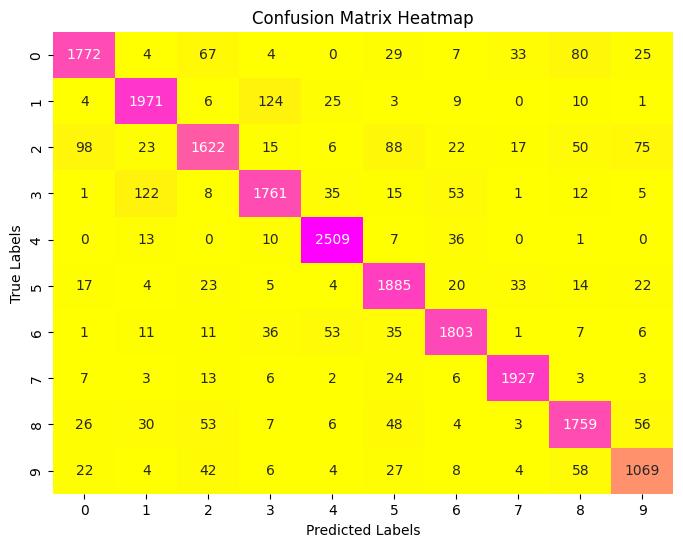

In [ ]:
conf_matrix = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='RdPu', cbar=False)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
report = classification_report(test_labels, test_preds)
print(report)

              precision    recall  f1-score   support

           0       0.91      0.88      0.89      2021
           1       0.90      0.92      0.91      2153
           2       0.88      0.80      0.84      2016
           3       0.89      0.87      0.88      2013
           4       0.95      0.97      0.96      2576
           5       0.87      0.93      0.90      2027
           6       0.92      0.92      0.92      1964
           7       0.95      0.97      0.96      1994
           8       0.88      0.88      0.88      1992
           9       0.85      0.86      0.85      1244

    accuracy                           0.90     20000
   macro avg       0.90      0.90      0.90     20000
weighted avg       0.90      0.90      0.90     20000

